# 52: Neural Style Transfer

## 🎯 Objective
Can we paint a photograph in the style of a famous painting? In this notebook, we implement **Neural Style Transfer**, a technique that blends the **content** of one image with the **artistic style** of another. We will use a pre-trained **VGG16** network to extract features and optimize a random noise image until it looks like the Taj Mahal painted in an abstract, "screaming" style.

## 📚 Key Concepts
* **VGG16:** A classic deep CNN trained on ImageNet. We use it as a fixed "feature extractor."
* **Content Representation:** High-level feature maps (deeper layers) capture the structure and objects in an image.
* **Style Representation (Gram Matrix):** The correlation between different feature maps in a layer captures texture and patterns (style), disregarding spatial arrangement.
* **Optimization Target:** Unlike standard training where we update network weights, here we freeze the network and update the **pixel values** of the target image to minimize the loss.

## 1. Import Libraries

We need `torch` and `torchvision` for the model and transforms. We use `imageio` to download images from URLs and `matplotlib` to view them.

In [1]:
# import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import torchvision.models as models

# to read an image from a url
import imageio.v2 as imageio

# for number-crunching
import numpy as np

# for data visualization
import matplotlib.pyplot as plt

## 2. Load and Freeze VGG16

We load the VGG16 network with pre-trained ImageNet weights. 

**Crucial Step:** We freeze all layers (`p.requires_grad = False`). We are *not* training VGG; we are using it to measure how similar our target image is to the content/style sources.

In [2]:
# Load VGG16 with ImageNet pretrained weights
vggnet = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

# freeze all layers
for p in vggnet.parameters():
    p.requires_grad = False

# set to evaluation mode (disables dropout, uses running stats for batchnorm)
vggnet.eval()

# send the network to the GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
vggnet.to(device);

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:03<00:00, 173MB/s]  


## 3. Data Preparation

We define three images:
1.  **Content Image:** The photograph we want to keep the structure of (e.g., Taj Mahal).
2.  **Style Image:** The artwork providing the texture/colors (e.g., an abstract painting).
3.  **Target Image:** The canvas we will paint on. We initialize this as **random noise**.

In [3]:
img4content = imageio.imread('https://imgs.search.brave.com/Dawah4iLQEuRHi_FeKL5JWbJXx3uPc2gWA_ClICa5vU/rs:fit:860:0:0:0/g:ce/aHR0cHM6Ly90aHVt/YnMuZHJlYW1zdGlt/ZS5jb20vYi9hbWF6/aW5nLXZpZXctdGFq/LW1haGFsLXdoaWNo/LXNldmVuLXdvcmxk/LXdvbmRlcnMtZmFt/b3VzLWluZGlhbi1p/c2xhbWljLWhlcml0/YWdlLWNsb3VkeS1k/YXktdGFqLW1haGFs/LWxvY2F0ZWQtNDEw/Mjk4MDY2LmpwZw')
img4style   = imageio.imread('https://imgs.search.brave.com/vsiYatKGtaKkHdyxxfwS3bH8DqratTGzTwHqdnj-nic/rs:fit:860:0:0:0/g:ce/aHR0cHM6Ly9pbWFn/ZXMudW5zcGxhc2gu/Y29tL3Bob3RvLTE1/NDE2ODA2NzA1NDgt/ODhlOGNkMjNjMGY0/P2ZtPWpwZyZxPTYw/Jnc9MzAwMCZpeGxp/Yj1yYi00LjEuMCZp/eGlkPU0zd3hNakEz/ZkRCOE1IeHpaV0Z5/WTJoOE9IeDhZWEow/ZDI5eWEzeGxibnd3/Zkh3d2ZIeDhNQT09')

# initialize the target image and random numbers
img4target = np.random.randint(low=0,high=255,size=img4content.shape,dtype=np.uint8)

print(img4content.shape)
print(img4target.shape)
print(img4style.shape)

(534, 800, 3)
(534, 800, 3)
(1081, 860, 3)


### Preprocessing
VGG requires images to be normalized with specific mean and standard deviation values. We also resize images to 256x256 to speed up the process.

In [4]:
## These images are really large, which will make training take a long time.

# create the transforms
Ts = T.Compose([ T.ToTensor(),
                 T.Resize(256),
                 T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
               ])

# apply them to the images ("unsqueeze" to make them a 4D tensor) and push to GPU
img4content = Ts( img4content ).unsqueeze(0).to(device)
img4style   = Ts( img4style   ).unsqueeze(0).to(device)
img4target  = Ts( img4target  ).unsqueeze(0).to(device)

print(img4content.shape)
print(img4target.shape)
print(img4style.shape)

torch.Size([1, 3, 256, 383])
torch.Size([1, 3, 256, 383])
torch.Size([1, 3, 321, 256])


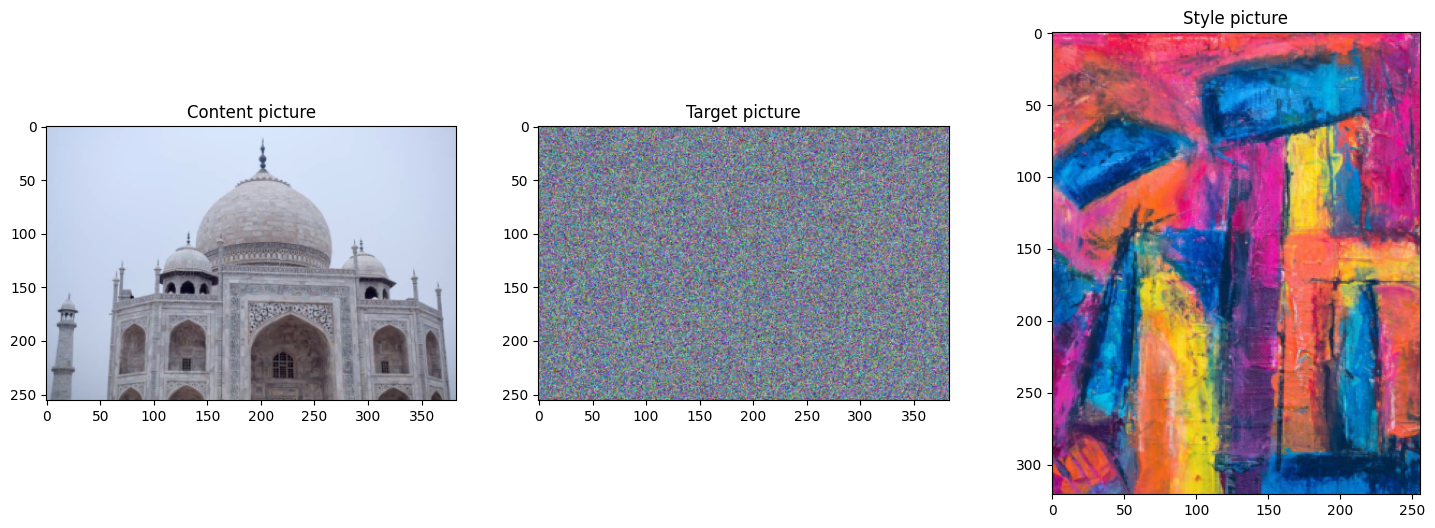

In [5]:
# Let's have a look at the "before" pics
fig,ax = plt.subplots(1,3,figsize=(18,6))

pic = img4content.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content picture')

pic = img4target.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[1].imshow(pic)
ax[1].set_title('Target picture')

pic = img4style.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[2].imshow(pic)
ax[2].set_title('Style picture')

plt.show()

## 4. Feature Extraction Helpers

To compute loss, we need access to the intermediate outputs of VGG. PyTorch's `vggnet.features` is a sequential container. We iterate through it, passing the image layer-by-layer, and save the output whenever we encounter a Conv2d layer.

### The Gram Matrix
The core of style transfer is the Gram Matrix. For a feature map $F$ of shape $(C, H, W)$, we reshape it to $(C, H \times W)$ and compute the dot product with its transpose:
$$G = \frac{1}{N} F \cdot F^T$$
This discards spatial information (where things are) and keeps texture information (which features tend to activate together).

In [6]:
# A function that returns feature maps

def getFeatureMapActs(img,net):

  # initialize feature maps as a list
  featuremaps = []
  featurenames = []

  convLayerIdx = 0

  # loop through all layers in the "features" block
  for layernum in range(len(net.features)):

    # process the image through this layer
    img = net.features[layernum](img)

    # store the image if it's a conv2d layer
    if 'Conv2d' in str(net.features[layernum]):
      featuremaps.append( img )
      featurenames.append( 'ConvLayer_' + str(convLayerIdx) )
      convLayerIdx += 1

  return featuremaps,featurenames

In [7]:
# A function that returns the Gram matrix of the feature activation map

def gram_matrix(M):

  # reshape to 2D
  _,chans,height,width = M.shape
  M = M.reshape(chans,height*width)

  # compute and return covariance matrix
  gram = torch.mm(M,M.t()) / (chans*height*width)
  return gram

## 5. Visualizing Features and Gram Matrices

It helps to see what these look like. 
* **Feature Maps:** Show what the network "sees" (edges, shapes).
* **Gram Matrices:** Abstract "checkerboard" patterns representing the style signature.

In [8]:
# inspect the output of the function
featmaps,featnames = getFeatureMapActs(img4content,vggnet)

# print out some info
for i in range(len(featnames)):
  print('Feature map "%s" is size %s'%(featnames[i],(featmaps[i].shape)))

Feature map "ConvLayer_0" is size torch.Size([1, 64, 256, 383])
Feature map "ConvLayer_1" is size torch.Size([1, 64, 256, 383])
Feature map "ConvLayer_2" is size torch.Size([1, 128, 128, 191])
Feature map "ConvLayer_3" is size torch.Size([1, 128, 128, 191])
Feature map "ConvLayer_4" is size torch.Size([1, 256, 64, 95])
Feature map "ConvLayer_5" is size torch.Size([1, 256, 64, 95])
Feature map "ConvLayer_6" is size torch.Size([1, 256, 64, 95])
Feature map "ConvLayer_7" is size torch.Size([1, 512, 32, 47])
Feature map "ConvLayer_8" is size torch.Size([1, 512, 32, 47])
Feature map "ConvLayer_9" is size torch.Size([1, 512, 32, 47])
Feature map "ConvLayer_10" is size torch.Size([1, 512, 16, 23])
Feature map "ConvLayer_11" is size torch.Size([1, 512, 16, 23])
Feature map "ConvLayer_12" is size torch.Size([1, 512, 16, 23])


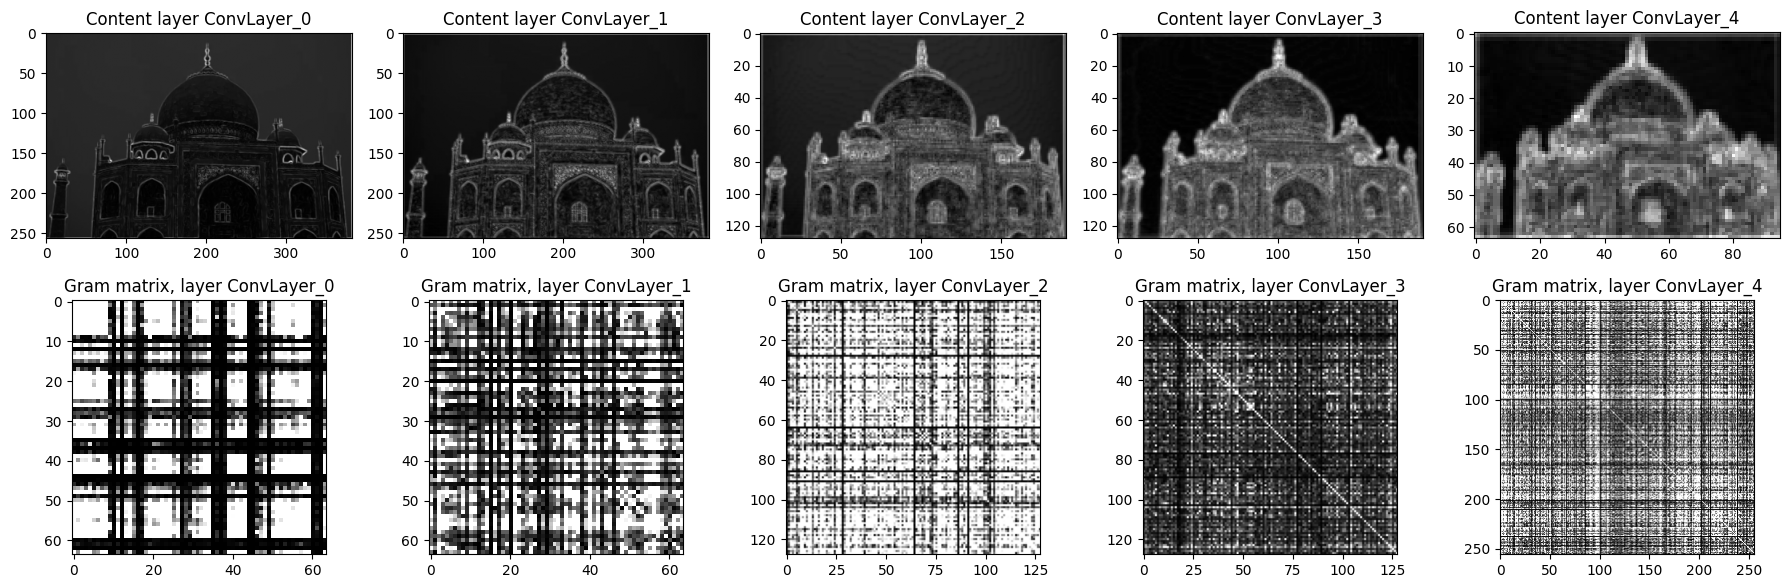

In [9]:
# let's see what the "content" image looks like
contentFeatureMaps,contentFeatureNames = getFeatureMapActs(img4content,vggnet)


fig,axs = plt.subplots(2,5,figsize=(18,6))
for i in range(5):

  # average over all feature maps from this layer, and normalize
  pic = np.mean( contentFeatureMaps[i].cpu().squeeze().numpy() ,axis=0)
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  axs[0,i].imshow(pic,cmap='gray')
  axs[0,i].set_title('Content layer ' + str(contentFeatureNames[i]))


  ### now show the gram matrix
  pic = gram_matrix(contentFeatureMaps[i]).cpu().numpy()
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  axs[1,i].imshow(pic,cmap='gray',vmax=.1)
  axs[1,i].set_title('Gram matrix, layer ' + str(contentFeatureNames[i]))

plt.tight_layout()
plt.show()

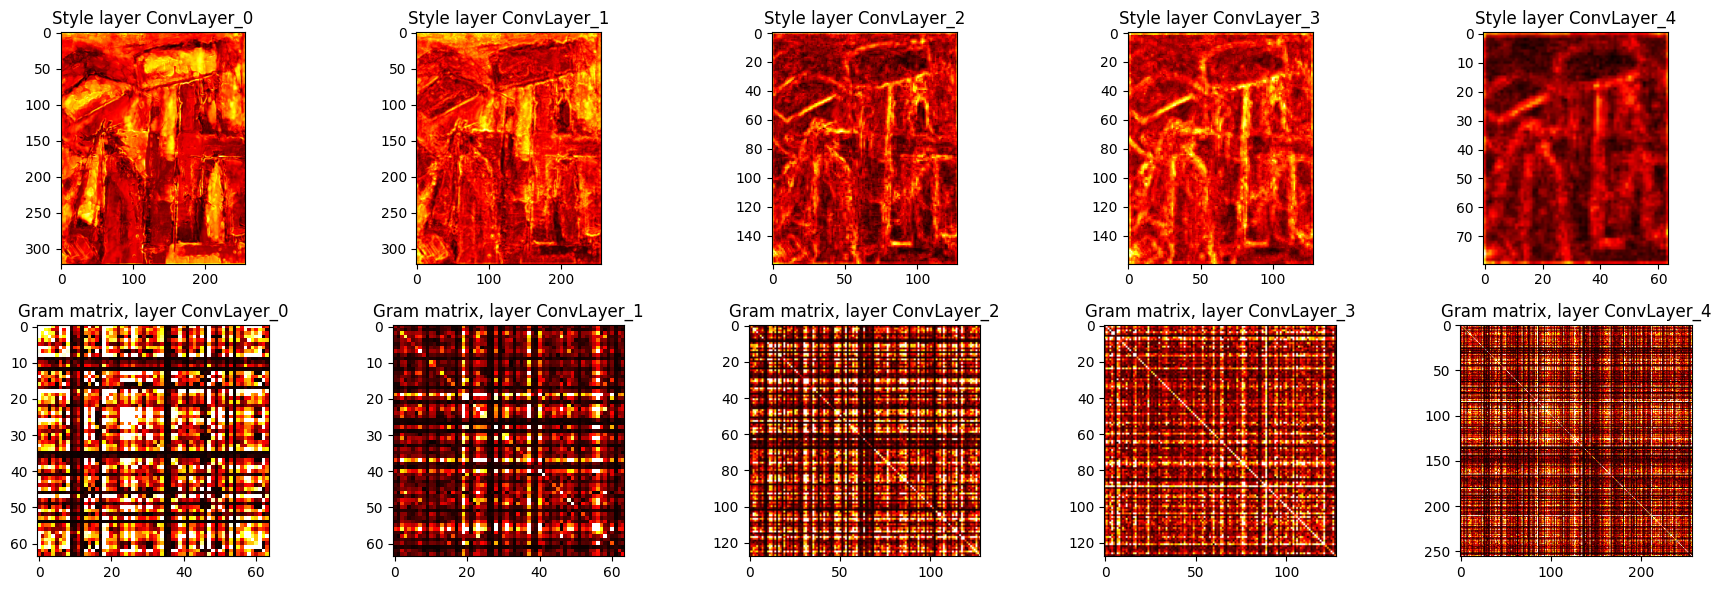

In [10]:

# repeat for the "style" image
styleFeatureMaps,styleFeatureNames = getFeatureMapActs(img4style,vggnet)


fig,axs = plt.subplots(2,5,figsize=(18,6))
for i in range(5):

  # average over all feature maps from this layer, and normalize
  pic = np.mean( styleFeatureMaps[i].cpu().squeeze().numpy() ,axis=0)
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  axs[0,i].imshow(pic,cmap='hot')
  axs[0,i].set_title('Style layer ' + str(styleFeatureNames[i]))


  ### now show the gram matrix
  pic = gram_matrix(styleFeatureMaps[i]).cpu().numpy()
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  axs[1,i].imshow(pic,cmap='hot',vmax=.1)
  axs[1,i].set_title('Gram matrix, layer ' + str(styleFeatureNames[i]))

plt.tight_layout()
plt.show()

## 6. Defining the Transfer

We decide which layers contribute to which loss:
* **Content Layers:** Earlier layers capture exact pixels; later layers capture shape. We pick a mix.
* **Style Layers:** We use multiple layers with different weights to capture texture at different scales.

In [11]:
# which layers to use
layers4content = [ 'ConvLayer_1','ConvLayer_4' ]
layers4style   = [ 'ConvLayer_1','ConvLayer_2','ConvLayer_3','ConvLayer_4','ConvLayer_5' ]
weights4style  = [      1       ,     .5      ,     .5      ,     .2      ,     .1       ]

## 7. The Optimization Loop

This is where the magic happens.
1.  **Clone Target:** We make a trainable copy of the random noise image.
2.  **`target.requires_grad = True`:** This tells PyTorch we want to update the *image itself* via backprop.
3.  **Loop:**
    * Extract features from the `target` image.
    * Calculate **Content Loss** (MSE between target features and content features).
    * Calculate **Style Loss** (MSE between target Gram matrices and style Gram matrices).
    * Sum them (weighted by `styleScaling`).
    * Backpropagate and update the image.

In [12]:
# make a copy of the target image and push to GPU
target = img4target.clone()
target.requires_grad = True
target = target.to(device)
styleScaling = 1e5

# number of epochs to train
numepochs = 1500

# optimizer for backprop
optimizer = torch.optim.RMSprop([target],lr=.005)


for epochi in range(numepochs):

  # extract the target feature maps
  targetFeatureMaps,targetFeatureNames = getFeatureMapActs(target,vggnet)


  # initialize the individual loss components
  styleLoss = 0
  contentLoss = 0

  # loop over layers
  for layeri in range(len(targetFeatureNames)):


    # compute the content loss
    if targetFeatureNames[layeri] in layers4content:
      contentLoss += torch.mean( (targetFeatureMaps[layeri]-contentFeatureMaps[layeri])**2 )


    # compute the style loss
    if targetFeatureNames[layeri] in layers4style:

      # Gram matrices
      Gtarget = gram_matrix(targetFeatureMaps[layeri])
      Gstyle  = gram_matrix(styleFeatureMaps[layeri])

      # compute their loss (de-weighted with increasing depth)
      styleLoss += torch.mean( (Gtarget-Gstyle)**2 ) * weights4style[layers4style.index(targetFeatureNames[layeri])]


  # combined loss
  combiloss = styleScaling*styleLoss + contentLoss

  # finally ready for backprop!
  optimizer.zero_grad()
  combiloss.backward()
  optimizer.step()

## 8. Results

We visualize the final `target` image. We use `torch.sigmoid` to ensure pixel values stay valid (0-1 range) for display.

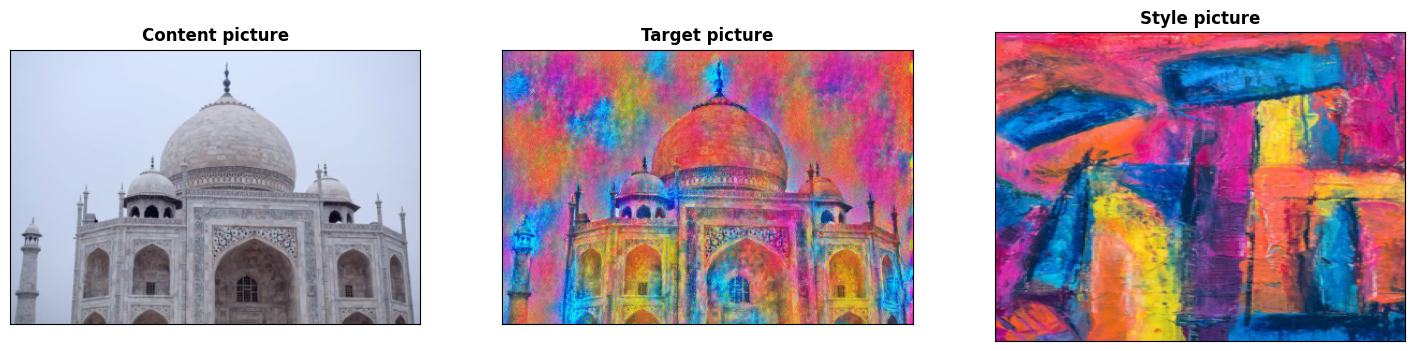

In [13]:
# the "after" pic
fig,ax = plt.subplots(1,3,figsize=(18,11))

pic = img4content.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content picture',fontweight='bold')
ax[0].set_xticks([])
ax[0].set_yticks([])

pic = torch.sigmoid(target).cpu().detach().squeeze().numpy().transpose((1,2,0))
ax[1].imshow(pic)
ax[1].set_title('Target picture',fontweight='bold')
ax[1].set_xticks([])
ax[1].set_yticks([])

pic = img4style.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[2].imshow(pic,aspect=.6)
ax[2].set_title('Style picture',fontweight='bold')
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.show()